In [ ]:
import os
import tensorflow        as tf
import matplotlib.pyplot as plt
import numpy             as np
from tensorflow          import keras

In [3]:
print(tf.__version__)
tf.config.list_physical_devices()

2.14.0


2024-10-08 10:56:10.038214: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
train_dir     = 'train' 
val_dir       = 'val'

batch_size    = 64
img_size      = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=123,
                                                            batch_size=batch_size,
                                                            image_size=img_size)

val_dataset   = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 seed=123,
                                                                 batch_size=batch_size,
                                                                 image_size=img_size)


Found 9469 files belonging to 10 classes.


2024-10-19 12:52:50.590664: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3925 files belonging to 10 classes.


In [4]:
from labels import class_labels

class_labels

['tench',
 'english springer',
 'cassette player',
 'chain saw',
 'church',
 'french horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [5]:
#normalize data
normalization_layer       = tf.keras.layers.Rescaling(scale=1./255)
train_dataset             = train_dataset.map(lambda x, y:(normalization_layer(x), tf.one_hot(y, depth=10)))
val_dataset               = val_dataset.map(lambda x, y:(normalization_layer(x),  tf.one_hot(y, depth=10)))

image_batch, labels_batch = next(iter(train_dataset))
first_image               = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
for image, labels in train_dataset.take(1):
    print("Batch of images shape:", image.shape)
    print("Batch of labels shape:" ,labels.shape)

Batch of images shape: (64, 224, 224, 3)
Batch of labels shape: (64, 10)


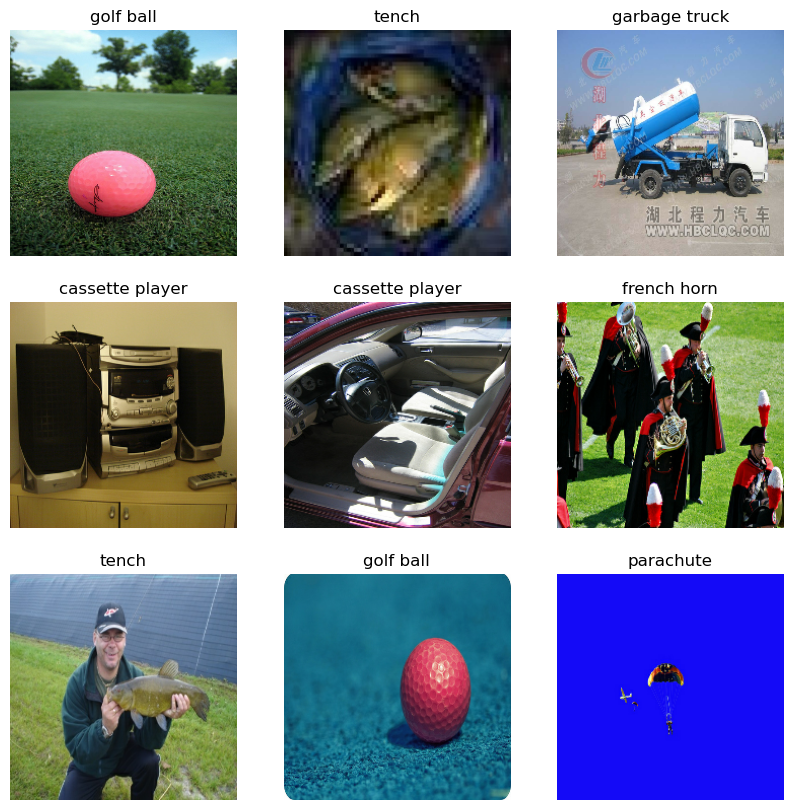

In [7]:
plt.figure(figsize = (10,10))
for image, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("double"))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(class_labels[label_index])
        plt.axis("off")

In [6]:
val_batches  = tf.data.experimental.cardinality(val_dataset) #calculates the num of batches in the validation set
test_dataset = val_dataset.take(val_batches // 5) # take the first 20% of the val dataset to create the new test set
val_dataset  = val_dataset.skip(val_batches // 5) # skip the first 20% of the val dataset to keep remaining 80% as the new val set.

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print("number of images in validation set :", len(val_dataset)*batch_size)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print("number of images in test set :", len(test_dataset)*batch_size)

Number of validation batches: 50
number of images in validation set : 3200
Number of test batches: 12
number of images in test set : 768


In [184]:
# import shutil

# test_dataset.save('test_dataset')
# shutil.make_archive('test_dataset', 'zip', 'test_dataset')

'/home/s2310144/workshop/Underspecification/imagenette/test_dataset.zip'

# build models

In [17]:
from keras.layers import GlobalAveragePooling2D, Dense, Lambda, Dropout
from keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.backend import epsilon
from tensorflow.keras.initializers import GlorotUniform

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [18]:
# set a global seed
tf.random.set_seed(42)
initializer = GlorotUniform(seed=42)

def add_classifier(base_model, num_classes = 10, initializer = initializer):
    x       = base_model.output
    x       = GlobalAveragePooling2D()(x)
    x       = Dropout(0.2)(x)
    x       = Dense(512, activation ='relu', kernel_initializer = initializer)(x)
    x       = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation ='softmax', kernel_initializer = initializer)(x)

    return outputs

def compile_and_train(model, train_dataset, val_dataset, epochs=10):
    model.compile(
        optimizer = Adam(),
        loss      = 'categorical_crossentropy',
        metrics   = ['accuracy',
                    Precision(name = 'precision'),
                    Recall(name    = 'recall'),
                    AUC(name       = 'auc'),
                    F1Score(name   = 'f1_score')
                    ]
    )

    history = model.fit(train_dataset,
                       epochs          = epochs,
                       validation_data = val_dataset
                       )
    return history

In [74]:
def plot_performance(model_history, model_name):
    plt.figure(figsize=(10,5))

    # plot accuracy 
    plt.subplot(2,3,1)
    plt.plot(model_history.history['accuracy'], label     = 'Training Accurary')
    plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuarcy')
    plt.legend()
    plt.title(f'{model_name} Accuracy')
    
    #plot loss
    plt.subplot(2,3,2)
    plt.plot(model_history.history['loss'], label     = 'Training Loss')
    plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Loss')
    
    plt.subplot(2,3,3)
    plt.plot(model_history.history['precision'], label     = 'Training Precision')
    plt.plot(model_history.history['val_precision'], label = 'Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'{model_name} Precision')
    
    plt.subplot(2,3,4)
    plt.plot(model_history.history['recall'], label     = 'Training Recall')
    plt.plot(model_history.history['val_recall'], label = 'Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(f'{model_name} Recall')
    
    plt.subplot(2,3,5)
    plt.plot(model_history.history['auc'], label     = 'Training AUC')
    plt.plot(model_history.history['val_auc'], label = 'Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.title(f'{model_name} AUC')
    
    plt.subplot(2,3,6)
    plt.plot(model_history.history['f1_score'], label     = 'Training F1-Score')
    plt.plot(model_history.history['val_f1_score'], label = 'Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title(f'{model_name} F1-Score')
    
    plt.tight_layout()
    plt.show()

In [ ]:
%%time
# base xception
base_xception           = tf.keras.applications.Xception(include_top = False,
                                                         input_shape = (224,224,3),
                                                         weights     = 'imagenet')
base_xception.trainable = False
xception_outputs        = add_classifier(base_xception)
xception                = tf.keras.Model(inputs = base_xception.input,
                                        outputs = xception_outputs,
                                        name    = 'Xception_imgnette')
xception_history        = compile_and_train(xception,
                                            train_dataset,
                                            val_dataset)

#save the model if accuracy thresholds are met
train_acc_xcep          = max(xception_history.history['accuracy'])
val_acc_xcep            = max(xception_history.history['val_accuracy'])

if train_acc_xcep > 0.95 and val_acc_xcep > 0.95:
    xception.save('models/diff_extrcs/xcep_imgnette.h5')
    print('Model saved as xcep_imgnette.h5')

Epoch 1/10
148/148 [==============================] - 51s 330ms/step - loss: 0.1195 - accuracy: 0.9653 - precision: 0.9846 - recall: 0.9506 - auc: 0.9982 - f1_score: 0.9673 - val_loss: 0.0456 - val_accuracy: 0.9861 - val_precision: 0.9908 - val_recall: 0.9842 - val_auc: 0.9994 - val_f1_score: 0.9874
Epoch 2/10
148/148 [==============================] - 48s 321ms/step - loss: 0.0408 - accuracy: 0.9882 - precision: 0.9912 - recall: 0.9862 - auc: 0.9996 - f1_score: 0.9887 - val_loss: 0.0636 - val_accuracy: 0.9823 - val_precision: 0.9853 - val_recall: 0.9794 - val_auc: 0.9983 - val_f1_score: 0.9824
Epoch 3/10
148/148 [==============================] - 47s 317ms/step - loss: 0.0293 - accuracy: 0.9910 - precision: 0.9925 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9911 - val_loss: 0.0583 - val_accuracy: 0.9848 - val_precision: 0.9870 - val_recall: 0.9838 - val_auc: 0.9987 - val_f1_score: 0.9854
Epoch 4/10
148/148 [==============================] - 47s 318ms/step - loss: 0.0179 - accuracy: 0

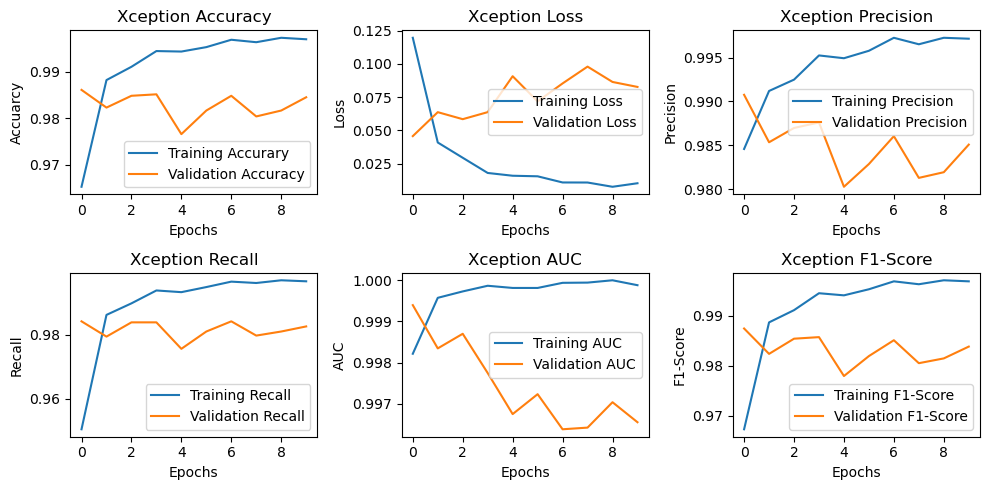

In [78]:
plot_performance(xception_history, 'Xception')

In [ ]:
%%time
base_incep           = tf.keras.applications.InceptionV3(include_top = False,
                                                         input_shape = (224,224,3),
                                                         weights     = 'imagenet')
base_incep.trainable = False
inception_outputs    = add_classifier(base_incep)
inception            = tf.keras.Model(inputs  = base_incep.input,
                                      outputs = inception_outputs,
                                      name    = 'InceptionV3_imgnette'
                                     )
inception_history    = compile_and_train(inception,
                                        train_dataset,
                                        val_dataset)

#save the model if accuracy thresholds are met
train_acc_incep      = inception_history.history['accuracy'][-1]
val_acc_incep        = inception_history.history['val_accuracy'][-1]

if train_acc_incep > 0.95 and val_acc_incep > 0.95:
    inception.save('models/diff_extrcs/incep_imgnette.h5')
    print('Model saved as incep_imgnette.h5')

Epoch 1/10
148/148 [==============================] - 29s 172ms/step - loss: 0.1633 - accuracy: 0.9546 - precision: 0.9720 - recall: 0.9464 - auc: 0.9963 - f1_score: 0.9590 - val_loss: 0.0711 - val_accuracy: 0.9775 - val_precision: 0.9806 - val_recall: 0.9762 - val_auc: 0.9988 - val_f1_score: 0.9784
Epoch 2/10
148/148 [==============================] - 24s 160ms/step - loss: 0.0699 - accuracy: 0.9798 - precision: 0.9842 - recall: 0.9773 - auc: 0.9984 - f1_score: 0.9807 - val_loss: 0.0699 - val_accuracy: 0.9807 - val_precision: 0.9834 - val_recall: 0.9785 - val_auc: 0.9985 - val_f1_score: 0.9809
Epoch 3/10
148/148 [==============================] - 24s 160ms/step - loss: 0.0438 - accuracy: 0.9865 - precision: 0.9894 - recall: 0.9849 - auc: 0.9992 - f1_score: 0.9871 - val_loss: 0.0571 - val_accuracy: 0.9832 - val_precision: 0.9873 - val_recall: 0.9823 - val_auc: 0.9981 - val_f1_score: 0.9848
Epoch 4/10
148/148 [==============================] - 24s 159ms/step - loss: 0.0367 - accuracy: 0

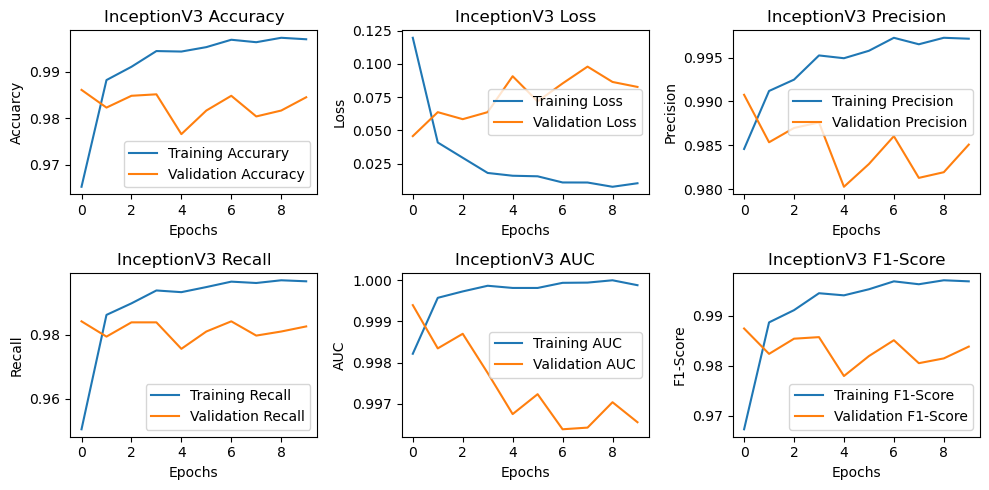

In [77]:
plot_performance(xception_history, 'InceptionV3')

In [ ]:
%%time
base_densenet           = tf.keras.applications.DenseNet121(include_top = False,
                                                            input_shape = (224,224,3),
                                                            weights     = 'imagenet')
base_densenet.trainable = False
densenet_outputs        = add_classifier(base_densenet)
densenet                = tf.keras.Model(inputs  = base_densenet.input,
                                         outputs = densenet_outputs,
                                         name    = 'DenseNet121_imgnette')
densenet_history        = compile_and_train(densenet,
                                           train_dataset,
                                           val_dataset)

#save the model if accuracy thresholds are met
train_acc_dense         = densenet_history.history['accuracy'][-1]
val_acc_dense           = densenet_history.history['val_accuracy'][-1]

if train_acc_dense > 0.95 and val_acc_dense > 0.95:
    densenet.save('models/diff_extrcs/dense_imgnette.h5')
    print('Model saved as dense_imgnette.h5')

Epoch 1/10
148/148 [==============================] - 60s 369ms/step - loss: 0.2450 - accuracy: 0.9238 - precision: 0.9557 - recall: 0.9037 - auc: 0.9948 - f1_score: 0.9289 - val_loss: 0.0761 - val_accuracy: 0.9731 - val_precision: 0.9767 - val_recall: 0.9693 - val_auc: 0.9995 - val_f1_score: 0.9730
Epoch 2/10
148/148 [==============================] - 53s 356ms/step - loss: 0.0955 - accuracy: 0.9701 - precision: 0.9759 - recall: 0.9666 - auc: 0.9987 - f1_score: 0.9712 - val_loss: 0.0463 - val_accuracy: 0.9867 - val_precision: 0.9882 - val_recall: 0.9829 - val_auc: 0.9997 - val_f1_score: 0.9855
Epoch 3/10
148/148 [==============================] - 53s 355ms/step - loss: 0.0757 - accuracy: 0.9734 - precision: 0.9784 - recall: 0.9697 - auc: 0.9991 - f1_score: 0.9740 - val_loss: 0.0599 - val_accuracy: 0.9810 - val_precision: 0.9850 - val_recall: 0.9785 - val_auc: 0.9989 - val_f1_score: 0.9817
Epoch 4/10
148/148 [==============================] - 53s 359ms/step - loss: 0.0621 - accuracy: 0

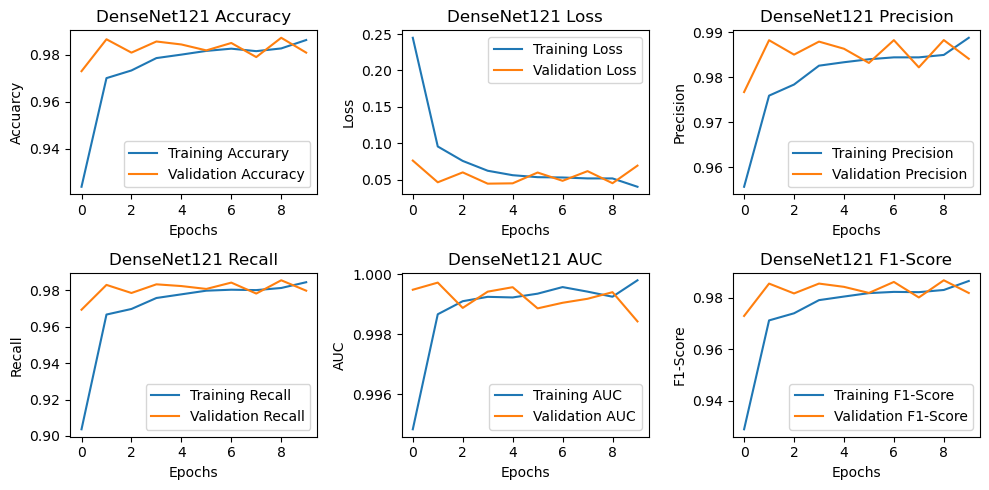

In [107]:
plot_performance(densenet_history, 'DenseNet121')

In [ ]:
%%time
base_resnet           = tf.keras.applications.ResNet50V2(include_top = False,
                                                       input_shape = (224,224,3),
                                                       weights     = 'imagenet'
                                                      )
base_resnet.trainable = False
resnet_outputs        = add_classifier(base_resnet)
resnet                = tf.keras.Model(inputs  = base_resnet.input,
                                       outputs = resnet_outputs,
                                       name    = 'Res50_imgnette'
                                      )
resnet_history        = compile_and_train(resnet,
                                           train_dataset,
                                           val_dataset)

#save the model if accuracy thresholds are met
train_acc_res         = resnet_history.history['accuracy'][-1]
val_acc_res           = resnet_history.history['val_accuracy'][-1]

if train_acc_res > 0.95 and val_acc_res > 0.95:
    resnet.save('models/diff_extrcs/resnet_imgnette.h5')
    print('Model saved as resnet_imgnette.h5')

Epoch 1/10
148/148 [==============================] - 40s 254ms/step - loss: 0.1947 - accuracy: 0.9413 - precision: 0.9580 - recall: 0.9354 - auc: 0.9955 - f1_score: 0.9466 - val_loss: 0.0722 - val_accuracy: 0.9762 - val_precision: 0.9809 - val_recall: 0.9737 - val_auc: 0.9991 - val_f1_score: 0.9773
Epoch 2/10
148/148 [==============================] - 35s 236ms/step - loss: 0.0822 - accuracy: 0.9735 - precision: 0.9775 - recall: 0.9699 - auc: 0.9987 - f1_score: 0.9737 - val_loss: 0.0781 - val_accuracy: 0.9743 - val_precision: 0.9786 - val_recall: 0.9724 - val_auc: 0.9987 - val_f1_score: 0.9755
Epoch 3/10
148/148 [==============================] - 36s 243ms/step - loss: 0.0486 - accuracy: 0.9831 - precision: 0.9851 - recall: 0.9817 - auc: 0.9994 - f1_score: 0.9834 - val_loss: 0.0698 - val_accuracy: 0.9775 - val_precision: 0.9812 - val_recall: 0.9762 - val_auc: 0.9990 - val_f1_score: 0.9787
Epoch 4/10
148/148 [==============================] - 36s 242ms/step - loss: 0.0336 - accuracy: 0

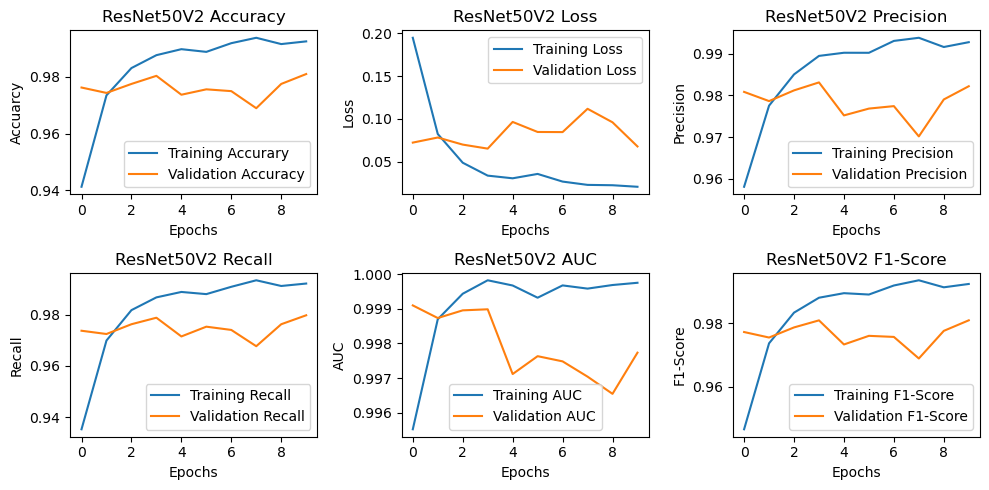

In [81]:
plot_performance(resnet_history, 'ResNet50V2')

////////////////////////////////////////////////////// With Different Optimizers ///////////////////////////////////////////////////

In [82]:
def train_with_diff_optimizers(model, train_dataset, val_dataset, optimizer, epochs=20):
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(name = 'precision'),
            Recall(name    = 'recall'),
            AUC(name       = 'auc'),
            F1Score(name   = 'f1_score')
        ]
    )

    print(f"Training model with {type(optimizer).__name__} optimizer...")
    
    history = model.fit(train_dataset,
                        epochs          = epochs,
                        validation_data = val_dataset)
    
    return history

In [86]:
%%time
densenet_adam  = tf.keras.Model(inputs  = base_densenet.input,
                                outputs = add_classifier(base_densenet),
                                name    = f'DenseNet121_adam')

adam_history   = train_with_diff_optimizers(densenet_adam,
                                             train_dataset,
                                             val_dataset,
                                             optimizer = Adam()
                                           )

train_acc_adam = adam_history.history['accuracy'][-1]
val_acc_adam   = adam_history.history['val_accuracy'][-1]

if train_acc_adam > 0.95 and val_acc_adam > 0.95:
    densenet_adam.save('models/diff_optimizers/dense_imgnette_adam.h5')
    print('Model saved as dense_imgnette_adam.h5')

Training model with Adam optimizer...
Epoch 1/20
148/148 [==============================] - 59s 364ms/step - loss: 0.2346 - accuracy: 0.9266 - precision: 0.9590 - recall: 0.9077 - auc: 0.9957 - f1_score: 0.9327 - val_loss: 0.0797 - val_accuracy: 0.9737 - val_precision: 0.9823 - val_recall: 0.9677 - val_auc: 0.9992 - val_f1_score: 0.9749
Epoch 2/20
148/148 [==============================] - 52s 351ms/step - loss: 0.0950 - accuracy: 0.9704 - precision: 0.9755 - recall: 0.9654 - auc: 0.9986 - f1_score: 0.9704 - val_loss: 0.0484 - val_accuracy: 0.9835 - val_precision: 0.9854 - val_recall: 0.9823 - val_auc: 0.9996 - val_f1_score: 0.9838
Epoch 3/20
148/148 [==============================] - 52s 352ms/step - loss: 0.0816 - accuracy: 0.9749 - precision: 0.9790 - recall: 0.9712 - auc: 0.9987 - f1_score: 0.9751 - val_loss: 0.0579 - val_accuracy: 0.9838 - val_precision: 0.9885 - val_recall: 0.9807 - val_auc: 0.9993 - val_f1_score: 0.9846
Epoch 4/20
148/148 [==============================] - 52s 3

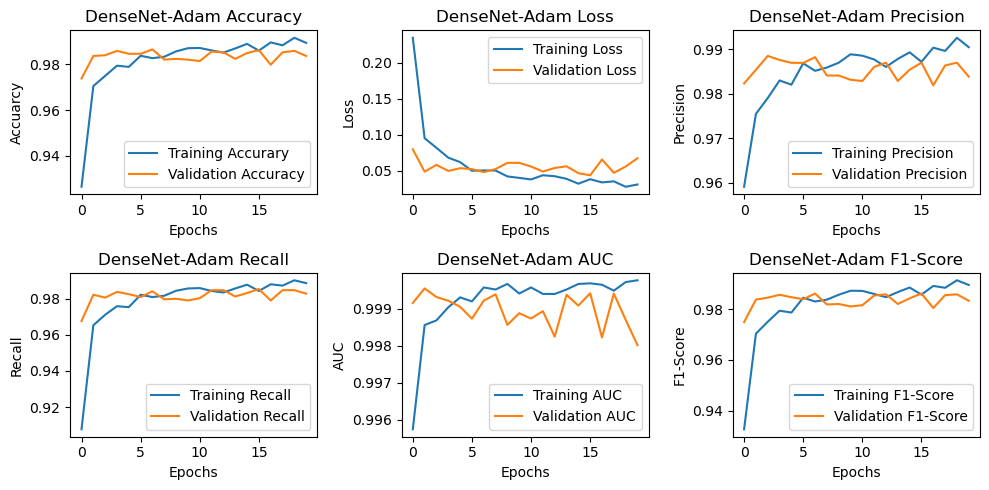

In [89]:
plot_performance(adam_history, 'DenseNet-Adam')

In [83]:
%%time
densenet_adagrad  = tf.keras.models.clone_model(base_densenet)
densenet_adagrad  = tf.keras.Model(inputs = densenet_agagrad.input,
                                  outputs = add_classifier(densenet_adagrad),
                                  name    = f'DenseNet121_adagrad')

adagrad_history   = train_with_diff_optimizers(densenet_adagrad,
                                             train_dataset,
                                             val_dataset,
                                             optimizer = Adagrad())

train_acc_adagrad = adagrad_history.history['accuracy'][-1]
val_acc_adagrad   = adagrad_history.history['val_accuracy'][-1]

if train_acc_adagrad > 0.95 and val_acc_adagrad > 0.95:
    densenet_adagrad.save('models/diff_optimizers/dense_imgnette_adagrad.h5')
    print('Model saved as dense_imgnette_adagrad.h5')

Training model with Adagrad optimizer...
Epoch 1/20
148/148 [==============================] - 60s 363ms/step - loss: 1.3902 - accuracy: 0.5581 - precision: 0.8288 - recall: 0.3253 - auc: 0.8833 - f1_score: 0.4672 - val_loss: 0.4579 - val_accuracy: 0.9446 - val_precision: 0.9952 - val_recall: 0.7928 - val_auc: 0.9977 - val_f1_score: 0.8826
Epoch 2/20
148/148 [==============================] - 52s 353ms/step - loss: 0.5683 - accuracy: 0.8569 - precision: 0.9508 - recall: 0.7258 - auc: 0.9859 - f1_score: 0.8232 - val_loss: 0.2499 - val_accuracy: 0.9591 - val_precision: 0.9892 - val_recall: 0.9009 - val_auc: 0.9989 - val_f1_score: 0.9430
Epoch 3/20
148/148 [==============================] - 52s 351ms/step - loss: 0.3891 - accuracy: 0.8990 - precision: 0.9615 - recall: 0.8308 - auc: 0.9932 - f1_score: 0.8914 - val_loss: 0.1828 - val_accuracy: 0.9639 - val_precision: 0.9892 - val_recall: 0.9303 - val_auc: 0.9993 - val_f1_score: 0.9589
Epoch 4/20
148/148 [==============================] - 52

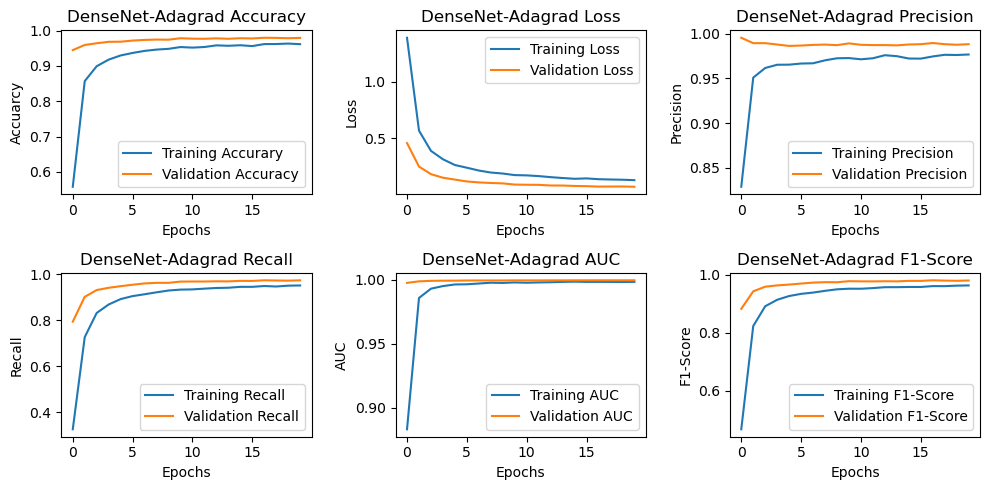

In [84]:
plot_performance(adagrad_history, 'DenseNet-Adagrad')

In [92]:
%%time
densenet_sgd = tf.keras.models.clone_model(base_densenet)
densenet_sgd = tf.keras.Model(inputs = densenet_sgd.input,
                            outputs  = add_classifier(densenet_sgd),
                            name     = f'DenseNet121_SGD')
sgd_history  = train_with_diff_optimizers(densenet_sgd,
                                         train_dataset,
                                         val_dataset,
                                         optimizer = tf.keras.optimizers.SGD()
                                        )

Training model with SGD optimizer...
Epoch 1/20
148/148 [==============================] - 59s 366ms/step - loss: 0.6937 - accuracy: 0.7970 - precision: 0.9359 - recall: 0.6771 - auc: 0.9731 - f1_score: 0.7857 - val_loss: 0.1522 - val_accuracy: 0.9667 - val_precision: 0.9837 - val_recall: 0.9389 - val_auc: 0.9994 - val_f1_score: 0.9608
Epoch 2/20
148/148 [==============================] - 52s 350ms/step - loss: 0.2289 - accuracy: 0.9348 - precision: 0.9661 - recall: 0.9041 - auc: 0.9971 - f1_score: 0.9341 - val_loss: 0.1010 - val_accuracy: 0.9734 - val_precision: 0.9838 - val_recall: 0.9595 - val_auc: 0.9996 - val_f1_score: 0.9715
Epoch 3/20
148/148 [==============================] - 52s 351ms/step - loss: 0.1723 - accuracy: 0.9494 - precision: 0.9699 - recall: 0.9326 - auc: 0.9978 - f1_score: 0.9509 - val_loss: 0.0826 - val_accuracy: 0.9778 - val_precision: 0.9868 - val_recall: 0.9690 - val_auc: 0.9997 - val_f1_score: 0.9778
Epoch 4/20
148/148 [==============================] - 52s 34

In [95]:
train_acc_sgd = sgd_history.history['accuracy'][-1]
val_acc_sgd   = sgd_history.history['val_accuracy'][-1]

if train_acc_sgd > 0.95 and val_acc_sgd > 0.95:
    densenet_sgd.save('models/diff_optimizers/dense_imgnette_sgd.h5')
    print('Model saved as dense_imgnette_sgd.h5')

Model saved as ense_imgnette_sgd.h5


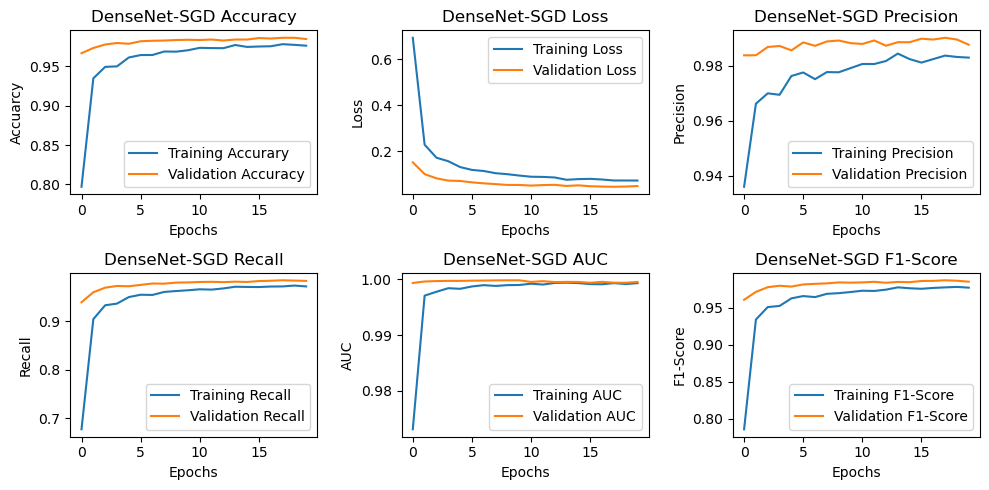

In [94]:
plot_performance(sgd_history, 'DenseNet-SGD')

In [108]:
%%time
densenet_rmsp  = tf.keras.models.clone_model(base_densenet)
densenet_rmsp  = tf.keras.Model(inputs   = densenet_rmsp.input,
                                outputs  = add_classifier(densenet_rmsp),
                                name     = f'DenseNet121_rmsp')

rmsp_history   = train_with_diff_optimizers(densenet_rmsp,
                                         train_dataset,
                                         val_dataset,
                                         optimizer = tf.keras.optimizers.RMSprop()
                                        )
train_acc_rmsp = rmsp_history.history['accuracy'][-1]
val_acc_rmsp   = rmsp_history.history['val_accuracy'][-1]

if train_acc_rmsp > 0.95 and val_acc_rmsp > 0.95:
    densenet_rmsp.save('models/diff_optimizers/dense_imgnette_rmsp.h5')
    print('Model saved as dense_imgnette_rmsp.h5')

Training model with RMSprop optimizer...
Epoch 1/20
148/148 [==============================] - 60s 371ms/step - loss: 0.2943 - accuracy: 0.9160 - precision: 0.9448 - recall: 0.8970 - auc: 0.9921 - f1_score: 0.9203 - val_loss: 0.0585 - val_accuracy: 0.9804 - val_precision: 0.9856 - val_recall: 0.9762 - val_auc: 0.9993 - val_f1_score: 0.9809
Epoch 2/20
148/148 [==============================] - 53s 356ms/step - loss: 0.1192 - accuracy: 0.9650 - precision: 0.9700 - recall: 0.9616 - auc: 0.9969 - f1_score: 0.9657 - val_loss: 0.0532 - val_accuracy: 0.9810 - val_precision: 0.9835 - val_recall: 0.9788 - val_auc: 0.9997 - val_f1_score: 0.9811
Epoch 3/20
148/148 [==============================] - 53s 354ms/step - loss: 0.0951 - accuracy: 0.9718 - precision: 0.9751 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9720 - val_loss: 0.0663 - val_accuracy: 0.9807 - val_precision: 0.9835 - val_recall: 0.9800 - val_auc: 0.9988 - val_f1_score: 0.9818
Epoch 4/20
148/148 [==============================] - 53

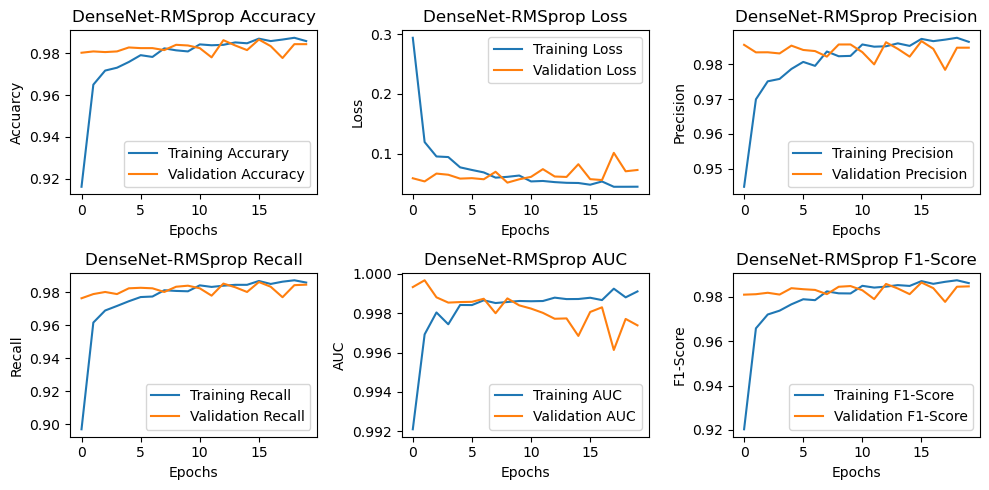

In [109]:
plot_performance(rmsp_history, 'DenseNet-RMSprop')

In [113]:
%%time
densenet_nadam  = tf.keras.models.clone_model(base_densenet)
densenet_nadam  = tf.keras.Model(inputs  = densenet_nadam.input,
                                outputs  = add_classifier(densenet_nadam),
                                name     = f'DenseNet121_nadam')

nadam_history   = train_with_diff_optimizers(densenet_nadam,
                                         train_dataset,
                                         val_dataset,
                                         optimizer = tf.keras.optimizers.Nadam()
                                        )
train_acc_nadam = nadam_history.history['accuracy'][-1]
val_acc_nadam   = nadam_history.history['val_accuracy'][-1]

if train_acc_nadam > 0.95 and val_acc_nadam > 0.95:
    densenet_nadam.save('models/diff_optimizers/dense_imgnette_nadam.h5')
    print('Model saved as dense_imgnette_nadam.h5')

Training model with Nadam optimizer...
Epoch 1/20
148/148 [==============================] - 59s 363ms/step - loss: 0.2659 - accuracy: 0.9196 - precision: 0.9596 - recall: 0.8899 - auc: 0.9945 - f1_score: 0.9234 - val_loss: 0.0601 - val_accuracy: 0.9823 - val_precision: 0.9891 - val_recall: 0.9788 - val_auc: 0.9993 - val_f1_score: 0.9839
Epoch 2/20
148/148 [==============================] - 52s 351ms/step - loss: 0.0895 - accuracy: 0.9701 - precision: 0.9755 - recall: 0.9665 - auc: 0.9988 - f1_score: 0.9710 - val_loss: 0.0559 - val_accuracy: 0.9810 - val_precision: 0.9853 - val_recall: 0.9778 - val_auc: 0.9995 - val_f1_score: 0.9816
Epoch 3/20
148/148 [==============================] - 52s 348ms/step - loss: 0.0805 - accuracy: 0.9726 - precision: 0.9778 - recall: 0.9694 - auc: 0.9990 - f1_score: 0.9736 - val_loss: 0.0447 - val_accuracy: 0.9864 - val_precision: 0.9885 - val_recall: 0.9845 - val_auc: 0.9994 - val_f1_score: 0.9865
Epoch 4/20
148/148 [==============================] - 52s 

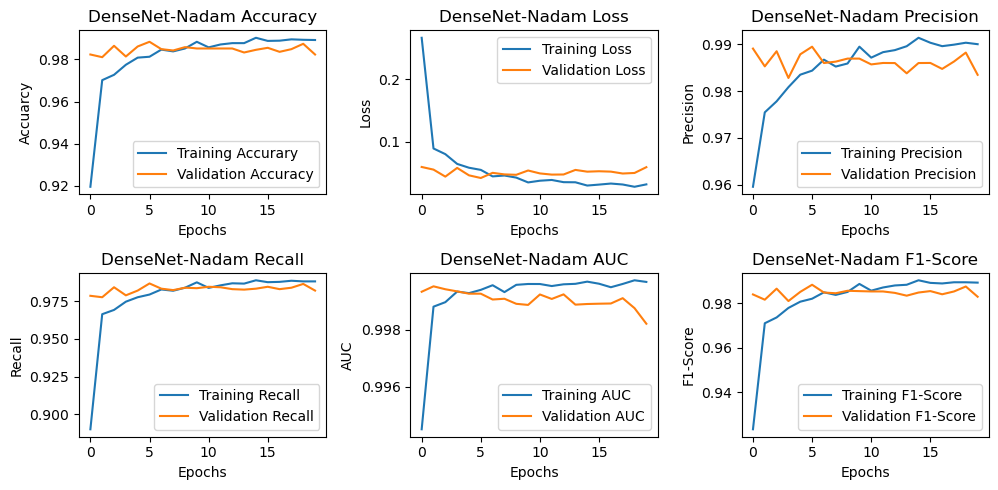

In [114]:
plot_performance(nadam_history, 'DenseNet-Nadam')

In [ ]:
# Models of Different Architecture
models_encoders   = []

save_dir = "models/diff_extrcs"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models_encoders.append(model)

for model_file in models_encoders:
    print(model_file.name)

Xception_imgnette
InceptionV3_imgnette
DenseNet121_imgnette
Res50_imgnette


In [34]:
results = []

for model in models_encoders:
    loss, acc, pre, re, auc, f1 = model.evaluate(test_dataset)

    f1_mean = np.mean(f1)
    results.append({
        'Model'     : model.name,
        'Loss'      : loss,
        'Accuracy'  : acc,
        'Precision' : pre,
        'Recall'    : re,
        'AUC'       : auc,
        'F1Score'   : f1_mean
    })
    # print(f"{model.name} : Loss : {loss}, Acc : {acc}, Precision : {pre}, Recall : {re}, AUC : {auc}, F1Score : {f1}")

12/12 [==============================] - 2s 188ms/step - loss: 0.1025 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9977 - f1_score: 0.9766


In [35]:
import pandas

df = pandas.DataFrame(results)
df

,Model,Loss,Accuracy,Precision,Recall,AUC,F1Score
0,Xception_imgnette,0.089243,0.983073,0.984355,0.983073,0.997734,0.983297
1,InceptionV3_imgnette,0.093084,0.972656,0.975196,0.972656,0.998429,0.971070
2,DenseNet121_imgnette,0.082909,0.977865,0.980341,0.973958,0.997768,0.977397
3,Res50_imgnette,0.102465,0.976562,0.976562,0.976562,0.997667,0.976613
